### Dataset

We use yfinance to download 5 years of historical data for NVIDIA. We’ll focus on the “Close” price for modeling.

In [15]:
import yfinance as yf
import pandas as pd

ticker = "NVDA"
df = yf.download(ticker, period="5y")

# reset index to make 'Date' a column
df.reset_index(inplace=True)

# display the first few rows
df.head()

/tmp/ipython-input-15-911012200.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA
0,2020-06-25,9.458820,9.473771,9.152082,9.325012,376072000
1,2020-06-26,9.124922,9.468789,9.095021,9.468789,592084000
2,2020-06-29,9.169776,9.174262,8.870761,9.139626,342248000
3,2020-06-30,9.466547,9.494953,9.236057,9.283401,367892000
4,2020-07-01,9.498690,9.544290,9.382074,9.489470,326648000


### Exploratory Data Analysis (EDA)

Understanding the data helps guide preprocessing and model selection. We’ll:
* Plot the closing price over time
* Plot the distribution of daily returns
* Visualize moving average trends

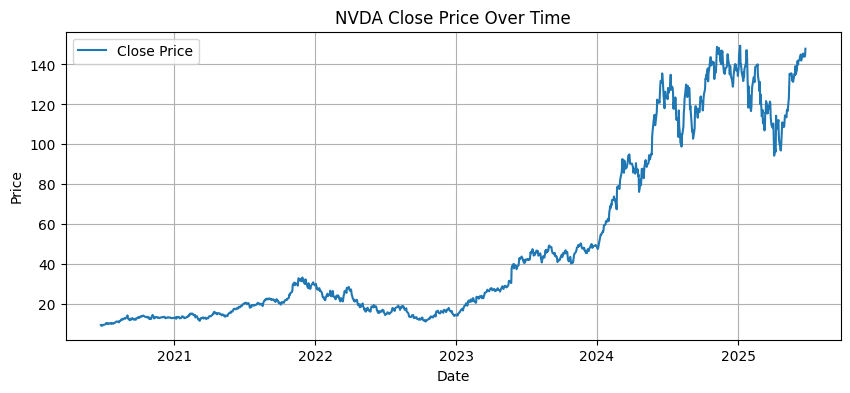

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

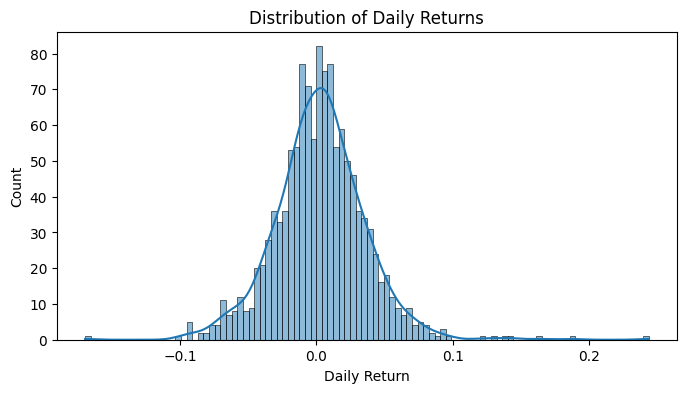

In [58]:
df['Return'] = df['Close'].pct_change()
plt.figure(figsize=(8, 4))
sns.histplot(df['Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.show()

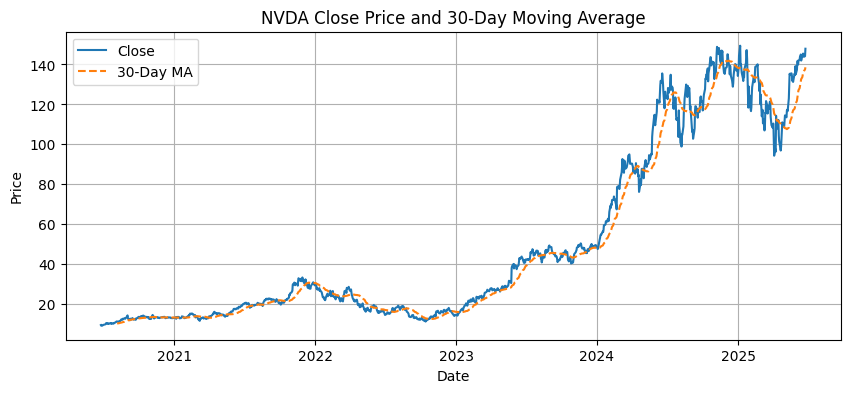

In [19]:
df['MA30'] = df['Close'].rolling(window=30).mean()
plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA30'], label='30-Day MA', linestyle='--')
plt.title('NVDA Close Price and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Data Cleaning

We drop missing values (if any), and normalize the closing prices using MinMaxScaler to scale them between 0 and 1 — this helps RNNs train more effectively.


In [63]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# close_prices = df[['Date', 'Close']]

# # drop missing values
# close_prices.dropna(inplace=True)

# # use only the price values for scaling
# scaler = MinMaxScaler()
# scaled_close = scaler.fit_transform(close_prices['Close'].values.reshape(-1, 1))

# We will try out adding other features
df['Return'] = df['Close'].pct_change()
df['MA7'] = df['Close'].rolling(7).mean()
df['MA30'] = df['Close'].rolling(30).mean()
df['Volatility'] = df['Close'].rolling(7).std()
df['Volume_norm'] = MinMaxScaler().fit_transform(df[['Volume']])

# Drop initial NaNs
df.dropna(inplace=True)

# feature columns
features = df[['Close', 'Return', 'MA7', 'MA30', 'Volatility', 'Volume_norm']]
scaled = MinMaxScaler().fit_transform(features.values)

**Sequence Generation & Dataset Split**

We create sequences of 30 time steps as input and 1 step ahead as the label. Then we split into training and validation sets (80/20 split).

The idea is to look back 30 days to predict the stock prices.

In [67]:
def create_multivariate_sequences(data, target_idx=0, lookback=30):
    """
    Args:
        data: np.array of shape (num_timesteps, num_features)
        target_idx: index of the column to be predicted (e.g., 0 for 'Close')
        lookback: number of past time steps to use as input

    Returns:
        X: (num_samples, lookback, num_features)
        y: (num_samples, 1)
    """
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback, target_idx])
    return np.array(X), np.array(y)

lookback = 30
X, y = create_multivariate_sequences(scaled, target_idx=0, lookback=lookback)

split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

### Model Architecture

Model Design (Vanilla RNN with 1 hidden layer)
- Input: sequences of shape (30, 1)
- RNN Layer: 1 hidden layer with 64 units
- Fully Connected Layer: output 1 scalar value (regression)
- Loss Function: MSE (Mean Squared Error)

We use a simple RNN because it captures temporal dependencies across a fixed window. ReLU activation and one fully connected layer keeps the architecture light and fast to train.

In [70]:
import torch
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

### Training Script

We use MSE loss and Adam optimizer. We’ll track and log loss and a custom accuracy (based on directional prediction).

In [75]:
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float().unsqueeze(-1)
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float().unsqueeze(-1)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

input_size = X_train.shape[2]
model = StockLSTM(input_size=input_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# training loop
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for X_batch, y_batch in train_bar:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    with torch.no_grad():
        for X_batch, y_batch in val_bar:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 1/5 | Train Loss: 0.0444 | Val Loss: 0.4573


Epoch 2/5 | Train Loss: 0.0407 | Val Loss: 0.4165


Epoch 3/5 | Train Loss: 0.0419 | Val Loss: 0.3794


Epoch 4/5 | Train Loss: 0.0353 | Val Loss: 0.3381


Epoch 5/5 | Train Loss: 0.0322 | Val Loss: 0.3013


**Loss Curve**



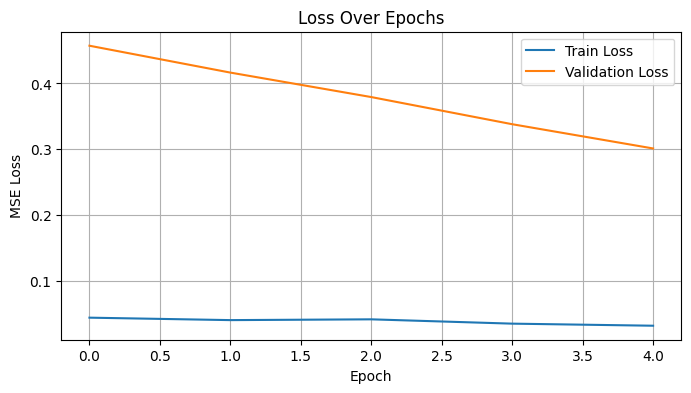

In [76]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

### Hyper Parameters Tuning

Based on the initial training on a few epochs, it looks like our model is learning well.


We will do hyper paramters tuning.

In [77]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout if num_layers > 1 else 0.0,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

### Train, Validation, Test Split

We will split into three dataset for efficient training and evaluation.

In [88]:
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float().unsqueeze(-1)
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float().unsqueeze(-1)

In [90]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# fixd
hidden_size = 64
num_layers = 1
dropout = 0.2

# tubable
learning_rates = [1e-3, 1e-4]
batch_sizes = [32, 64]
epoch_options = [5, 10, 20]

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in epoch_options:

            print(f"\nTraining config: lr={lr}, batch_size={batch_size}, epochs={num_epochs}")

            # Prepare DataLoaders
            train_loader = DataLoader(
                TensorDataset(X_train_tensor, y_train_tensor),
                batch_size=batch_size, shuffle=True
            )
            val_loader = DataLoader(
                TensorDataset(X_val_tensor, y_val_tensor),
                batch_size=batch_size, shuffle=False
            )

            # Model and optimizer
            model = StockLSTM(
                input_size=X_train.shape[2],
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout
            )
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Training loop
            for epoch in range(num_epochs):
                model.train()
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    output = model(X_batch)
                    loss = criterion(output, y_batch)
                    loss.backward()
                    optimizer.step()

            # Validation loop
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    output = model(X_batch)
                    val_loss += criterion(output, y_batch).item()
            avg_val_loss = val_loss / len(val_loader)

            results.append({
                "lr": lr,
                "batch_size": batch_size,
                "num_epochs": num_epochs,
                "val_loss": avg_val_loss
            })

            print(f"→ Val Loss: {avg_val_loss:.4f}")


Training config: lr=0.001, batch_size=32, epochs=5
→ Val Loss: 0.0030

Training config: lr=0.001, batch_size=32, epochs=10
→ Val Loss: 0.0041

Training config: lr=0.001, batch_size=32, epochs=20
→ Val Loss: 0.0021

Training config: lr=0.001, batch_size=64, epochs=5
→ Val Loss: 0.0025

Training config: lr=0.001, batch_size=64, epochs=10
→ Val Loss: 0.0036

Training config: lr=0.001, batch_size=64, epochs=20
→ Val Loss: 0.0076

Training config: lr=0.0001, batch_size=32, epochs=5
→ Val Loss: 0.2423

Training config: lr=0.0001, batch_size=32, epochs=10
→ Val Loss: 0.0087

Training config: lr=0.0001, batch_size=32, epochs=20
→ Val Loss: 0.0063

Training config: lr=0.0001, batch_size=64, epochs=5
→ Val Loss: 0.4814

Training config: lr=0.0001, batch_size=64, epochs=10
→ Val Loss: 0.1294

Training config: lr=0.0001, batch_size=64, epochs=20
→ Val Loss: 0.0033


In [91]:
best = sorted(results, key=lambda x: x["val_loss"])[0]
print("\n Best Configuration:")
print(best)


 Best Configuration:
{'lr': 0.001, 'batch_size': 32, 'num_epochs': 20, 'val_loss': 0.0020940699469065294}


### Evaluation

We will evaluate on the test set to see how good the model is.

In [100]:
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float().unsqueeze(-1)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

model.eval()
test_loss = 0.0
all_preds, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        test_loss += criterion(preds, y_batch).item()
        all_preds.append(preds)
        all_targets.append(y_batch)

avg_test_loss = test_loss / len(test_loader)
print(f"\nFinal Test Loss (MSE): {avg_test_loss:.4f}")


Final Test Loss (MSE): 0.0110


### Predictions

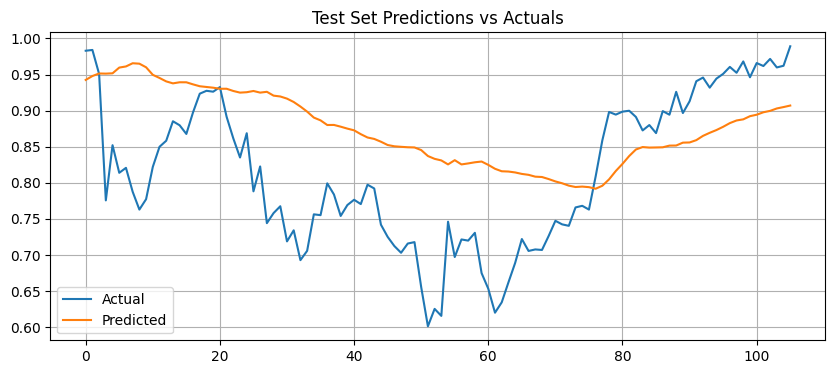

In [101]:
import matplotlib.pyplot as plt

y_pred = torch.cat(all_preds).squeeze().numpy()
y_true = torch.cat(all_targets).squeeze().numpy()

plt.figure(figsize=(10, 4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Test Set Predictions vs Actuals")
plt.legend()
plt.grid()
plt.show()

### Results & Analysis

Here we can see that the model isn't following exactly as the predictions in test set.

However, given the nature of stock market, the volume of the dataset and training restraint, we can say that the model did a good job following general trend.

**What worked and what didn't work?**

Initially I tried out using the close price alone. It didn't work and the validation loss stays as the straight line.

Therefore I tried out integrating multiple features. It turns out it worked well when combined with hyper paramters tuning.

### Conclusion

While the model isn’t perfect at capturing high-frequency noise, it does a solid job predicting the general trend of the price movements on the test set.

That will useful for many financial forecasting applications, especially in longer-term signals or directional strategies.

**Potential Improvements**
- Here we focus on hyper parameter tuning. In future, I would look into LSTM or GRU to capture long term dependencies
- Larger dataset, potentiall 15 years back
- Integrate external factors like news, related stocks, major events etc.,